In [1]:
import csv
import time

In [2]:
def read(filename, date_idx, date_parse, year, bucket=7):
    days_in_year = 365
    
    freq = {}
    for period in range(0, int(days_in_year / bucket)):
        freq[period] = 0
        
    with open(filename, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        next(csvreader)
        for row in csvreader:
            if row[date_idx] == '':
                continue
            
            t = time.strptime(row[date_idx], date_parse)
            if t.tm_year == year and t.tm_yday < (days_in_year-1):
                freq[int(t.tm_yday / bucket)] += 1
    
    return freq


In [3]:
freq = read('311.csv', 1, '%m/%d/%Y %H:%M:%S %p', 2014)

In [4]:
freq

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 10889,
 22: 40240,
 23: 42125,
 24: 42673,
 25: 41721,
 26: 38446,
 27: 41915,
 28: 41008,
 29: 39011,
 30: 36069,
 31: 38821,
 32: 37050,
 33: 36967,
 34: 26834,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: 0,
 51: 0}

Num samples 52


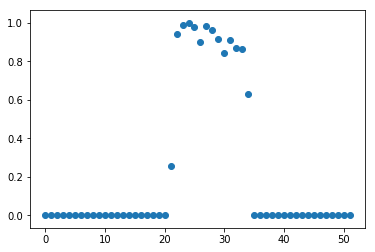

In [274]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

X_train = np.asarray(list(freq.keys()))
Y_train = np.asarray(list(freq.values()))
print("Num samples", str(len(X_train)))
maxY = np.max(Y_train)
nY_train = Y_train / np.max(Y_train)

plt.scatter(X_train, nY_train)
plt.show()

In [275]:
learning_rate = 0.001
training_epochs = 1000

X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)

def model(X, mu, sig):
    return tf.div(tf.negative(tf.pow(tf.subtract(X, mu), 2.)), tf.multiply(2., tf.pow(sig, 2.)))

mu = tf.Variable(18., name="mu")
sig = tf.Variable(21.5, name="sig")
y_model = model(X, mu, sig)

In [276]:
cost = tf.square(Y-y_model)
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [277]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [278]:
for epoch in range(training_epochs):
    for(x, y) in zip(X_train, nY_train):
        sess.run(train_op, feed_dict={X:x, Y:y})

In [279]:
mu_val = sess.run(mu)
sig_val = sess.run(sig)

In [280]:
print(mu_val)
print(sig_val)

19.438864
23.140743


In [281]:
sess.close()

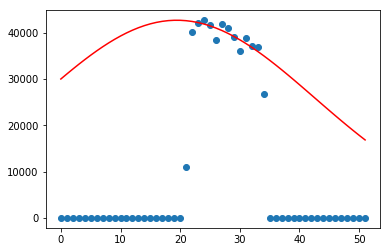

Prediction of week 35 35940.02835380378
Actual week 35 36967


In [282]:
plt.scatter(X_train, Y_train)
trY2 = maxY * (np.exp(-np.power(X_train - mu_val, 2.) / (2 * np.power(sig_val, 2.))))
plt.plot(X_train, trY2, 'r')
plt.show()
print("Prediction of week 35", trY2[33])
print("Actual week 35", Y_train[33])

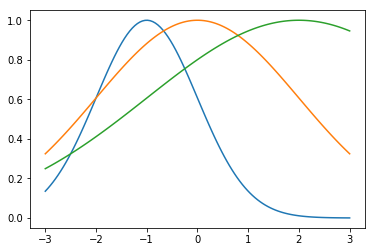

In [283]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
x_values = np.linspace(-3, 3, 120)
for mu, sig in [(-1, 1), (0, 2), (2, 3)]:
    plt.plot(x_values, gaussian(x_values, mu, sig))

plt.show()

# Try a polynomial model
We'll try a polynomial model now just to see.

In [284]:
learning_rate = 0.01
training_epochs = 40

#num_coeffs = 6
num_coeffs = 2
#trY_coeffs = [1, 2, 3, 4, 5, 6]
trY_coeffs = [1, 2]

X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)

def model(X, w):
    terms = []
    for i in range(num_coeffs):
        term = tf.multiply(w[i], tf.pow(X, i))
        terms.append(term)
    return tf.add_n(terms)

In [285]:
w = tf.Variable([0.] * num_coeffs, name="parameters")
y_model = model(X, w)
cost = (tf.pow(Y-y_model, 2))

In [286]:
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [287]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [288]:
for epoch in range(training_epochs):
    for(x, y) in zip(X_train, Y_train):
        sess.run(train_op, feed_dict={X:x, Y:y})

In [289]:
w_val = sess.run(w)
print(w_val)

[nan nan]


In [290]:
sess.close()

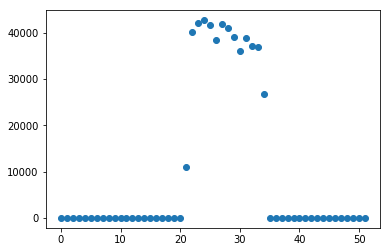

In [291]:
plt.scatter(X_train, Y_train)
trY2 = 0
for i in range(num_coeffs):
    trY2 += w_val[i] * np.power(X_train, i)
plt.plot(X_train, trY2, 'r')
plt.show()

# Use Regularization
We'll use regularlization and .7 / .3 train/test split to see if it helps.

In [393]:
def split_dataset(x_dataset, y_dataset, ratio):
    arr = np.arange(x_dataset.size)
    np.random.shuffle(arr)
    num_train = int(ratio * x_dataset.size)
    x_train = x_dataset[arr[0:num_train]]
    x_test = x_dataset[arr[num_train:x_dataset.size]]
    y_train = y_dataset[arr[0:num_train]]
    y_test = y_dataset[arr[num_train:x_dataset.size]]
    return x_train, x_test, y_train, y_test

In [394]:
(x_train, x_test, y_train, y_test) = split_dataset(X_train, nY_train, 0.7)

In [395]:
X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)

In [396]:
def model(X, mu, sig):
    return tf.div(tf.negative(tf.pow(tf.subtract(X, mu), 2.)), tf.multiply(2., tf.pow(sig, 2.)))

mu = tf.Variable(18., name="mu") # begin learning near the first shift for the curve
sig = tf.Variable(21.5, name="sig") # decreasing
y_model = model(X, mu, sig)

In [397]:
reg_lambda = 0.
cost = tf.div(tf.add(tf.reduce_sum(tf.square(Y-y_model)),
                     tf.multiply(reg_lambda, tf.reduce_sum(tf.square([mu, sig])))), 2*x_train.size)

In [398]:
learning_rate = 0.001
training_epochs = 1000
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [399]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [400]:
for reg_lambda in np.linspace(0, 1, 100):
    for epoch in range(training_epochs):
        sess.run(train_op, feed_dict = {X: x_train, Y: y_train})
    final_cost = sess.run(cost, feed_dict = {X: x_test, Y: y_test})
    print('reg lambda', reg_lambda)
    print('final cost', final_cost)

reg lambda 0.0
final cost 0.06843858
reg lambda 0.010101010101010102
final cost 0.06813244
reg lambda 0.020202020202020204
final cost 0.06783073
reg lambda 0.030303030303030304
final cost 0.06754384
reg lambda 0.04040404040404041
final cost 0.067259006
reg lambda 0.05050505050505051
final cost 0.066977054
reg lambda 0.06060606060606061
final cost 0.06670845
reg lambda 0.07070707070707072
final cost 0.06644171
reg lambda 0.08080808080808081
final cost 0.06617679
reg lambda 0.09090909090909091
final cost 0.06591368
reg lambda 0.10101010101010102
final cost 0.06565239
reg lambda 0.11111111111111112
final cost 0.06539289
reg lambda 0.12121212121212122
final cost 0.06513516
reg lambda 0.13131313131313133
final cost 0.0648792
reg lambda 0.14141414141414144
final cost 0.064624995
reg lambda 0.15151515151515152
final cost 0.064372525
reg lambda 0.16161616161616163
final cost 0.06413284
reg lambda 0.17171717171717174
final cost 0.06389698
reg lambda 0.18181818181818182
final cost 0.06366265
reg

In [401]:
mu_val = sess.run(mu)
sig_val = sess.run(sig)

In [402]:
print(mu_val)
print(sig_val)

19.470346
23.181498


In [403]:
sess.close()

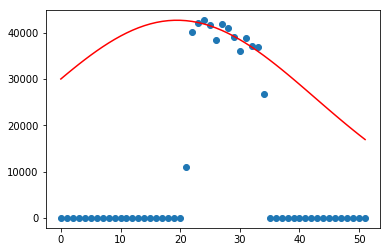

Prediction of week 35 35990.26439981846
Actual week 35 36967


In [404]:
plt.scatter(X_train, Y_train)
#trY2 = maxY * (np.exp(-np.power(X_train - mu_val-6.51195, 2.) / (2 * np.power(sig_val-16, 2.))))
trY2 = maxY * (np.exp(-np.power(X_train - mu_val, 2.) / (2 * np.power(sig_val, 2.))))
plt.plot(X_train, trY2, 'r')
plt.show()
print("Prediction of week 35", trY2[33])
print("Actual week 35", Y_train[33])

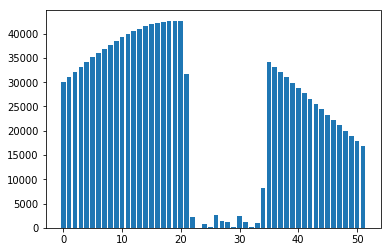

In [414]:
# plot the error
error = np.power(np.power(trY2 - Y_train, 2), 0.5)
#print(error)
plt.bar(X_train, error)
plt.show()